In [1]:
# Custom Modules import
from util.data_loader import load_competitions, load_matches
#from util.team_strength_team_stats import calculate_team_stats, calculate_chances_from_played_games, calculate_features_based_on_certain_matchweeks, generate_dataset, create_home_away_pairs
from util.team_strength_team_stats import *
from statsbombpy import sb
from statsbombpy.api_client import NoAuthWarning

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore', category=NoAuthWarning)



from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score


%load_ext autoreload 
%autoreload 2


##  1.0.3 Task 3: Player strength model

The goal is now to find a nuanced team strength model that represents teams in a more accurate way to make predictions. For that we first have to take a look at the dataset and at how to extract important features for our nuanced model.

### Legend:  
🔴- to do <br>
🟠- in progress <br>
🟢- done <br>


### Used Features to quantify Team Strength:
- 🟢 Possession
- 🟢 Shots on Goal/ 🔴 on Target
- 🟢 Goals 
- 🟢 Goals_conceded
- 🟢 X_Goals
- 🟢 Passes 
- 🟠 Duels


### Other Features used to predict Match Outcomes:
- 🔴 Last 5 matches


### Output Predictions
- 🟢 Label of Match Status for Home Team
- 🔴 Betting Odds for both Home and Away Team

### Trainings/Test Daten
<br>


### Prior Baseline (Aus Literatur Outcome Prediction Modelle anschauen)


# Event Types, etc.

Here we can see what details are hidden in the dataset. It consists of event data for every match where every event is a detailed description of what is happening with the ball during that moment of the game, as well as who is handling it, what type of shot it is, etc.. 

In [2]:
# Load data
matches = load_matches(competition_id=9, season_id=27)

test_event = sb.events(match_id=3890259)
test_event.shape

print('------------distinct_types----------------')
print(test_event['type'].unique())
print('------------pass_outcome----------------')
print(test_event['pass_outcome'].unique())
print('------------pass_type-------------')
print(test_event['pass_type'].unique())
print('------------pass_height----------------')
print(test_event['pass_height'].unique())

------------distinct_types----------------
['Starting XI' 'Half Start' 'Pass' 'Pressure' 'Ball Receipt*' 'Carry'
 'Duel' 'Clearance' 'Ball Recovery' 'Interception' 'Dispossessed'
 'Miscontrol' 'Block' 'Foul Committed' 'Foul Won' 'Shot' 'Goal Keeper'
 'Shield' '50/50' 'Dribble' 'Dribbled Past' 'Injury Stoppage' 'Player Off'
 'Player On' 'Half End' 'Error' 'Substitution' 'Tactical Shift']
------------pass_outcome----------------
[nan 'Incomplete' 'Out' 'Unknown' 'Pass Offside']
------------pass_type-------------
[nan 'Kick Off' 'Throw-in' 'Recovery' 'Free Kick' 'Goal Kick' 'Corner'
 'Interception']
------------pass_height----------------
[nan 'Ground Pass' 'High Pass' 'Low Pass']


# Getting the information out of the event dataframes

Now we have to get our important team features from the dataset. For that we defined a function that uses simple queries and applies them to the dataset. The function details are found in team_strength_team_stats.py .

The following displays the calculated stats for the first game of the 2015/2016 Bundesliga season as an example.

In [3]:
team_stats = calculate_team_stats(event=test_event)
team_stats

,team,completed_passes,total_passes,pass_completion_percentage,Shots,duels,xG,Goals,Goals Conceded,Possession
0,Bayern Munich,711,797,89.209536,22,76,2.24,5.0,0.0,78.0
1,Hamburger SV,150,240,62.500000,5,76,0.08,0.0,5.0,22.0


# All Matches of the 15/16 Bundesliga Season 
The following code now extracts the features out of every match but takes long to execute, since its pulling the data from the statsbomb API. Therefore it is written into and stored in a local .csv file.

In [4]:
'''
all_team_stats = []
for _, match in matches.iterrows(): 
   match_id = match['match_id'] 
   match_date = match['match_date']
   match_week = match['match_week']
   #print(f'Start gathering Information from Match_ID = {match_id}')
   match_stats = calculate_team_stats(sb.events(match_id=match_id))
   match_stats['match_id'] = match_id
   match_stats['match_date'] = match_date
   match_stats['match_week'] = match_week
   all_team_stats.append(match_stats)
#   match_day += 1

team_stats = pd.concat(all_team_stats, ignore_index=True).set_index('match_id')
team_stats.to_csv('./Data/team_strength_stats.csv')
'''

"\nall_team_stats = []\nfor _, match in matches.iterrows(): \n   match_id = match['match_id'] \n   match_date = match['match_date']\n   match_week = match['match_week']\n   #print(f'Start gathering Information from Match_ID = {match_id}')\n   match_stats = calculate_team_stats(sb.events(match_id=match_id))\n   match_stats['match_id'] = match_id\n   match_stats['match_date'] = match_date\n   match_stats['match_week'] = match_week\n   all_team_stats.append(match_stats)\n#   match_day += 1\n\nteam_stats = pd.concat(all_team_stats, ignore_index=True).set_index('match_id')\nteam_stats.to_csv('./Data/team_strength_stats.csv')\n"

We can now display the average statistics for every team in that particular season.

In [5]:
team_stats = pd.read_csv('./Data/team_strength_stats.csv')
team_stats['match_date'] = pd.to_datetime(team_stats['match_date'])
team_stats.sort_values('match_date')


#For example get the average pass completion percentage
team_stats.groupby(['team'])['pass_completion_percentage'].mean().reset_index(name='avg_pass_completion_percentage').sort_values('avg_pass_completion_percentage', ascending=False).head(20)

,team,avg_pass_completion_percentage
2,Bayern Munich,86.538269
3,Borussia Dortmund,82.751210
17,Wolfsburg,81.192701
4,Borussia Mönchengladbach,79.465608
14,Schalke 04,78.534258
11,Hertha Berlin,77.500490
0,Augsburg,74.321272
7,FC Köln,73.537738
1,Bayer Leverkusen,72.752820
12,Hoffenheim,72.739057


In [6]:

chances = calculate_chances_from_played_games(team_stats=team_stats, considered_matchweeks=list(range(1, 35)), round_decimals=None)
home_team = 'Bayern Munich'
away_team = 'Borussia Dortmund'
# This function creates a single entry which contains the stats of the teams, based on certain matchweeks and assigns the actual game result
single_datapoint = calculate_features_based_on_certain_matchweeks(home_team=home_team, away_team=away_team, chances=chances, matches=matches)

single_datapoint

,home_team,home_avg_completed_passes,home_avg_total_passes,home_avg_pass_comp_pct,home_avg_shots,home_avg_duels,home_avg_goals,away_team,away_avg_completed_passes,away_avg_total_passes,away_avg_pass_comp_pct,away_avg_shots,away_avg_duels,away_avg_goals,match_week,actual_result
0,Bayern Munich,662.205882,760.647059,86.538269,18.294118,68.058824,2.294118,Borussia Dortmund,565.911765,675.941176,82.75121,15.411765,72.5,2.352941,8,Home_Victory


# Generating Data

One problem we encountered while working with the dataset is that since we only have one season, it is going to be hard to properly train our model.
So we resulted to a method that generates match data we can train our model on based on the data that we already have. The generate_dataset function takes a subset of the season matchdays, calculates the statistics for each team and then creates fake pairings for one matchweek and uses the actual outcome of that pairing in the 15/16 season as a label for that data point. We can then tune the amount of weeks we want to simulate to train our model; here we picked 510 since that would correspond to having all the data from the 2000/2001 season onwards.

In [7]:
train_dataset = generate_dataset(team_stats=team_stats, matches=matches, amount_of_weeks_to_simulate=510)


In [8]:
X = train_dataset.drop(columns=['actual_result','match_week'])  # All columns except the target
y = train_dataset['actual_result']  # Just the target column

grid_search, X_test, y_test, X_train, y_train, preprocessor  = train_and_evaluate_model(X, y)

# Access the best model
best_model = grid_search.best_estimator_

Class distribution in y_train: actual_result
Home_Victory    1664
Home_Defeat     1134
Draw             874
Name: count, dtype: int64
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best model: GradientBoostingClassifier(learning_rate=0.5)
Best params: {'model': GradientBoostingClassifier(), 'model__learning_rate': 0.5, 'model__n_estimators': 100}
Best CV score: 0.931


In [9]:
test_brier_scores = create_brier_scores(X_test = X_test, y_test = y_test, model = best_model, dataset = train_dataset)
                    
brier_scores_week = test_brier_scores.groupby('match_week').agg(brier_score=('brier_score', 'mean'))

#print(f'Brier Score: {test_brier_scores['brier_score'].mean()}')
print(f'Brier Score {test_brier_scores["brier_score"].mean()}')
brier_scores_week 
test_brier_scores


Brier Score 0.1241015977981406


,predicted_Draw,predicted_Home_Defeat,predicted_Home_Victory,actual_Draw,actual_Home_Defeat,actual_Home_Victory,match_week,brier_score
3672,0.049688,0.004500,0.945812,0.0,0.0,1.0,409,0.005425
3673,0.036799,0.205838,0.757363,0.0,0.0,1.0,409,0.102596
3674,0.013478,0.882692,0.103830,0.0,1.0,0.0,409,0.024724
3675,0.033225,0.951400,0.015374,0.0,1.0,0.0,409,0.003702
3676,0.888926,0.091763,0.019312,1.0,0.0,0.0,409,0.021131
...,...,...,...,...,...,...,...,...
4585,0.152356,0.006959,0.840685,0.0,0.0,1.0,510,0.048642
4586,0.006946,0.883893,0.109160,0.0,1.0,0.0,510,0.025445
4587,0.686606,0.191060,0.122334,1.0,0.0,0.0,510,0.149686
4588,0.064534,0.599296,0.336170,0.0,1.0,0.0,510,0.277739


# Test with the Real Bundesliga 15/16 Matchdata

In the following we show what results we obtained after training our model(s) on the fake data. (hier bin ich stehengeblieben)

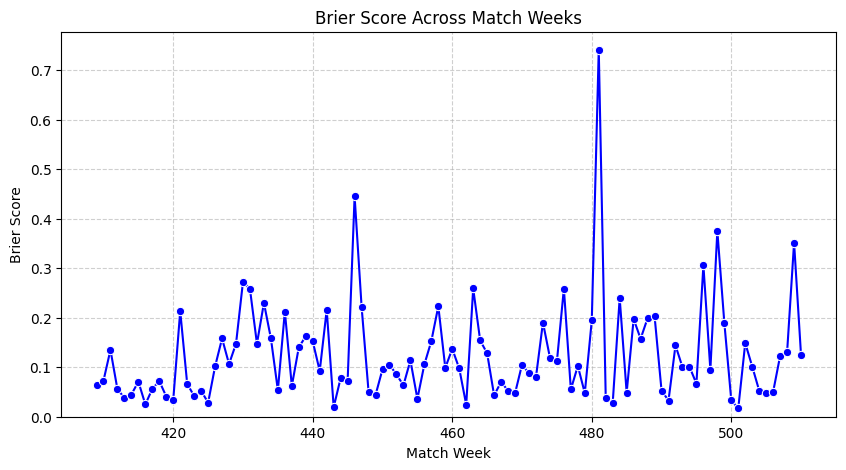

In [10]:
# Create the plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=brier_scores_week, x='match_week', y='brier_score', marker='o', color='blue')

# Customize the plot
plt.xlabel('Match Week')
plt.ylabel('Brier Score')
plt.title('Brier Score Across Match Weeks')
plt.ylim(0, None)
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()

In [11]:
real_bundesliga_dataset = generate_real_dataset(team_stats=team_stats, matches=matches)

In [12]:
X_real = real_bundesliga_dataset.drop(columns=['actual_result','match_week'])  # All columns except the target
y_real = real_bundesliga_dataset['actual_result']  # Just the target column
predictions_real = best_model.predict(X_real)

              precision    recall  f1-score   support

        Draw       0.88      0.90      0.89        71
 Home Defeat       0.96      0.89      0.92       100
Home Victory       0.91      0.95      0.93       135

    accuracy                           0.92       306
   macro avg       0.92      0.91      0.91       306
weighted avg       0.92      0.92      0.92       306



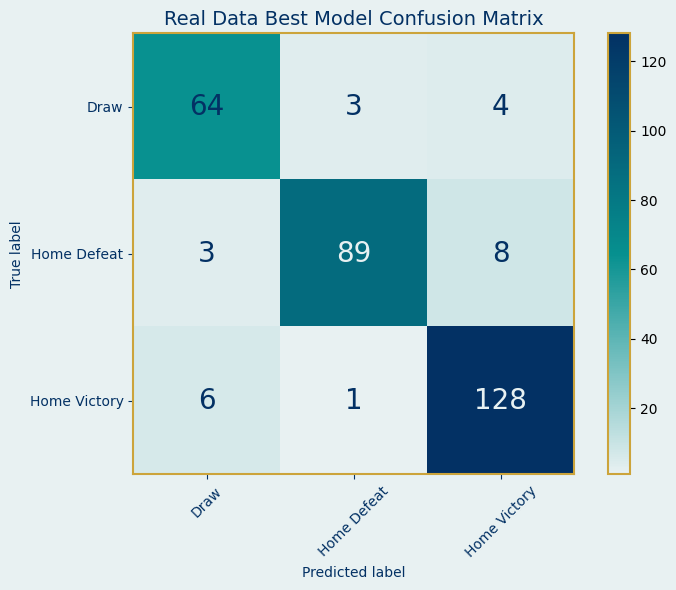

In [13]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Print classification report
print(
    classification_report(
        y_real,
        predictions_real,
        target_names=['Draw', 'Home Defeat', 'Home Victory']
    )
)

# Custom colormap
colors = ['#E8F1F2', '#06908F', '#033164']
custom_cmap = LinearSegmentedColormap.from_list("my_cmap", colors)

# Create figure and axes
fig, ax = plt.subplots(figsize=(8, 6), facecolor='#E8F1F2')
ax.set_facecolor('#E8F1F2')

# Plot confusion matrix with colorbar
disp = ConfusionMatrixDisplay.from_predictions(
    y_real,
    predictions_real,
    display_labels=['Draw', 'Home Defeat', 'Home Victory'],
    cmap=custom_cmap,
    xticks_rotation=45,
    ax=ax,
    colorbar=True
)

# Increase font size of the numbers inside the confusion matrix
for txt in disp.text_.flat:
    txt.set_fontsize(20)          # Make numbers bigger

# Color styling
text_color = '#033164'
gold_color = '#CCA43B'

# Title and labels
ax.set_title('Real Data Best Model Confusion Matrix', color=text_color, fontsize=14)
ax.set_xlabel('Predicted label', color=text_color)
ax.set_ylabel('True label', color=text_color)
ax.tick_params(colors=text_color)

# Tick label colors
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_color(text_color)

# Frame styling
for spine in ax.spines.values():
    spine.set_edgecolor(gold_color)
    spine.set_linewidth(1.5)

# Modify colorbar border
cbar = disp.im_.colorbar
for spine in cbar.ax.spines.values():
    spine.set_edgecolor(gold_color)
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.savefig('./Poster_stuff/Confusion_matrix.svg', bbox_inches='tight',pad_inches=0.2)
plt.show()
plt.close('all')


In [14]:
real_brier_scores = create_brier_scores(X_test = X_real, y_test = y_real, model = best_model, dataset = real_bundesliga_dataset)
                    
real_brier_scores_week = real_brier_scores.groupby('match_week').agg(brier_score=('brier_score', 'mean'))

print(f'Brier Score: {real_brier_scores["brier_score"].mean()}')

Brier Score: 0.13737411469284097


In [15]:
results = pd.DataFrame(grid_search.cv_results_)
best_params_per_model = results.groupby(
    results['param_model'].apply(lambda x: x.__class__.__name__)
).apply(
    lambda x: x.loc[x['mean_test_score'].idxmax(), 'params']
).to_dict()


best_models = {}
for model_name, params in best_params_per_model.items():
    # Create pipeline with best parameters
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', params['model'].set_params(**{
            k.split('__')[1]: v for k, v in params.items() 
            if k != 'model'
        }))
    ])
    
    # Retrain on full training data
    pipe.fit(X_train, y_train)
    best_models[model_name] = pipe

c:\Users\mathi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GaussianNB - Overall Brier Score: 0.7992
GradientBoostingClassifier - Overall Brier Score: 0.1358
KNeighborsClassifier - Overall Brier Score: 0.5219
LogisticRegression - Overall Brier Score: 0.5079
RandomForestClassifier - Overall Brier Score: 0.1925


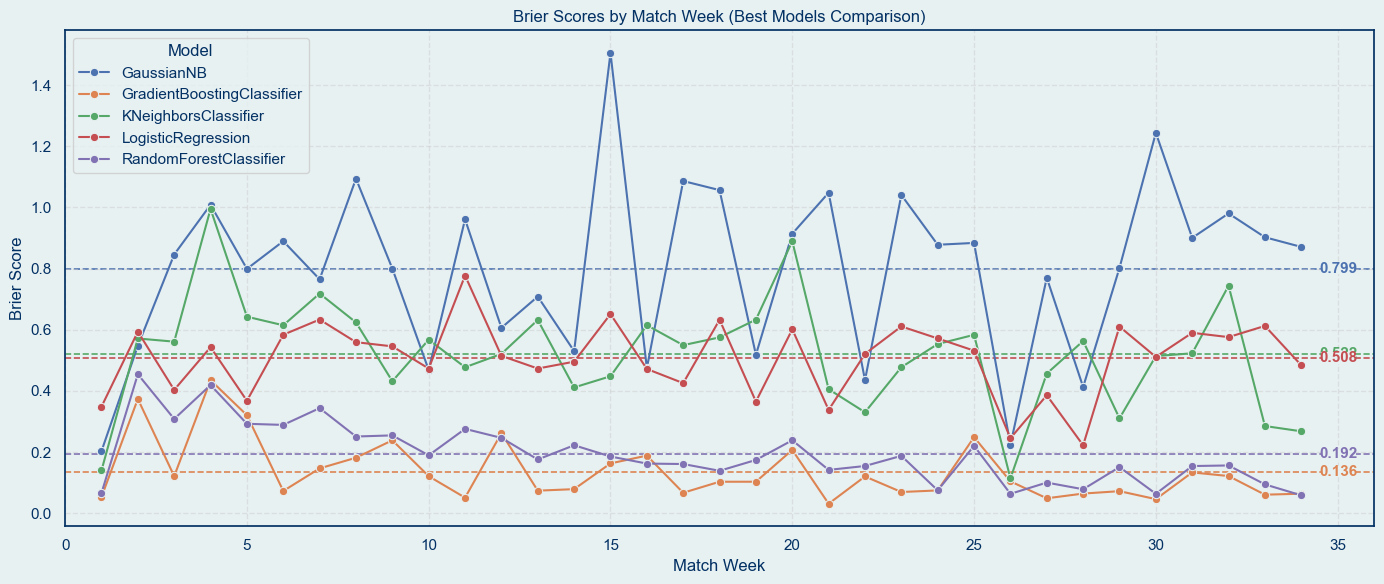

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate Brier scores
brier_results = {}
for model_name, model in best_models.items():
    # Get predictions and outcomes
    preds_and_outcomes = create_brier_scores(
        X_test=X_real,
        y_test=y_real,
        model=model,
        dataset=real_bundesliga_dataset
    )
    
    weekly_scores = preds_and_outcomes.groupby('match_week').agg(
        brier_score=('brier_score', 'mean')
    )

    # Store results
    brier_results[model_name] = {
        'predictions': preds_and_outcomes,
        'weekly_scores': weekly_scores,
        'overall_score': preds_and_outcomes['brier_score'].mean()
    }
    
    # Print summary
    print(f"{model_name} - Overall Brier Score: {brier_results[model_name]['overall_score']:.4f}")

# 2. Plot weekly Brier scores comparison
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(14, 6))

# Set background colors
fig.patch.set_facecolor('#E8F1F2')  # Around the plot
ax.set_facecolor('#E8F1F2')         # Plot area

# Create a consistent color palette for the models
color_palette = sns.color_palette(n_colors=len(brier_results))
model_colors = dict(zip(brier_results.keys(), color_palette))

# Plot each model
for model_name, results in brier_results.items():
    weekly_scores = results['weekly_scores'].reset_index()
    weekly_scores['model'] = model_name

    # Line for weekly Brier scores
    sns.lineplot(
        data=weekly_scores,
        x='match_week',
        y='brier_score',
        marker='o',
        label=model_name,
        ax=ax,
        color=model_colors[model_name],
        markeredgecolor='#E8F1F2', 
    )

    # Horizontal line for average Brier score (no legend)
    avg_score = results['overall_score']
    ax.axhline(
        y=avg_score,
        linestyle='--',
        linewidth=1.2,
        color=model_colors[model_name],
        zorder=0
    )
    ax.text(
        x=weekly_scores['match_week'].max() + 0.5,  # place just after the last week
        y=avg_score,
        s=f"{avg_score:.3f}",
        va='center',
        ha='left',
        color=model_colors[model_name],
        fontsize=11,
        fontweight='bold',
        bbox=dict(facecolor='#e8f1f2', edgecolor='none', alpha=1, pad=-1)
    )

# Axis titles and styling
ax.set_title('Brier Scores by Match Week (Best Models Comparison)', color='#033164')
ax.set_xlabel('Match Week', color='#033164')
ax.set_ylabel('Brier Score', color='#033164')
ax.tick_params(colors='#033164')

# Customize legend

legend = ax.legend(title='Model')
legend.get_frame().set_facecolor('#E8F1F2')  # Match background
legend.get_frame().set_linewidth(1)          # Optional: make it clean
plt.setp(legend.get_texts(), color='#033164')
plt.setp(legend.get_title(), color='#033164')
for spine in ax.spines.values():
    spine.set_edgecolor('#033164')  # Set spine color
# Grid and layout
ax.grid(True, linestyle='--', alpha=0.5)
plt.xlim (0,36)
plt.savefig('./Poster_stuff/Brier_scores_by_match_week.svg', bbox_inches='tight', pad_inches=0.2)
plt.tight_layout()
plt.show()




In [17]:

matches_spanish = load_matches(competition_id=11, season_id=27)


In [18]:
'''
all_team_stats = []
for _, match in matches_spanish.iterrows(): 
   match_id = match['match_id'] 
   match_date = match['match_date']
   match_week = match['match_week']
   #print(f'Start gathering Information from Match_ID = {match_id}')
   match_stats = calculate_team_stats(sb.events(match_id=match_id))
   match_stats['match_id'] = match_id
   match_stats['match_date'] = match_date
   match_stats['match_week'] = match_week
   all_team_stats.append(match_stats)

team_stats_spanish = pd.concat(all_team_stats, ignore_index=True).set_index('match_id')
team_stats_spanish.to_csv('./Data/team_strength_stats_spanish.csv')
'''

"\nall_team_stats = []\nfor _, match in matches_spanish.iterrows(): \n   match_id = match['match_id'] \n   match_date = match['match_date']\n   match_week = match['match_week']\n   #print(f'Start gathering Information from Match_ID = {match_id}')\n   match_stats = calculate_team_stats(sb.events(match_id=match_id))\n   match_stats['match_id'] = match_id\n   match_stats['match_date'] = match_date\n   match_stats['match_week'] = match_week\n   all_team_stats.append(match_stats)\n\nteam_stats_spanish = pd.concat(all_team_stats, ignore_index=True).set_index('match_id')\nteam_stats_spanish.to_csv('./Data/team_strength_stats_spanish.csv')\n"

In [19]:
team_stats_spanish = pd.read_csv('./Data/team_strength_stats_spanish.csv')
team_stats_spanish['match_date'] = pd.to_datetime(team_stats_spanish['match_date'])
team_stats_spanish.sort_values('match_date')


real_spanish_liga_dataset = generate_real_dataset(team_stats=team_stats_spanish, matches=matches_spanish)

X_real_spanish = real_spanish_liga_dataset.drop(columns=['actual_result','match_week'])  # All columns except the target
y_real_spanish = real_spanish_liga_dataset['actual_result']  # Just the target column
predictions_real_spanish = best_model.predict(X_real_spanish)

In [20]:
real_brier_scores_spanish = create_brier_scores(X_test = X_real_spanish, y_test = y_real_spanish, model = best_model, dataset = real_spanish_liga_dataset)
                    
real_brier_scores_week_spanish = real_brier_scores_spanish.groupby('match_week').agg(brier_score=('brier_score', 'mean'))

print(f'Brier Score: {real_brier_scores_spanish["brier_score"].mean()}')

Brier Score: 0.640676297932994


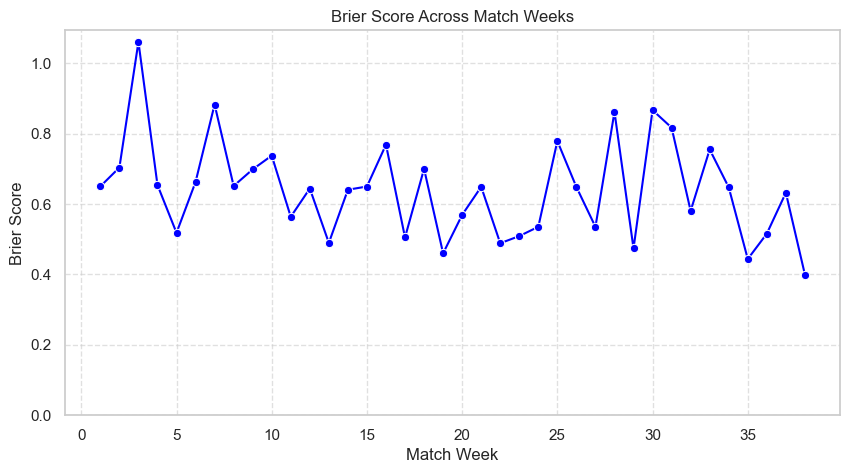

In [21]:
# Create the plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=real_brier_scores_week_spanish, x='match_week', y='brier_score', marker='o', color='blue')

# Customize the plot
plt.xlabel('Match Week')
plt.ylabel('Brier Score')
plt.title('Brier Score Across Match Weeks')
plt.ylim(0, None)
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()

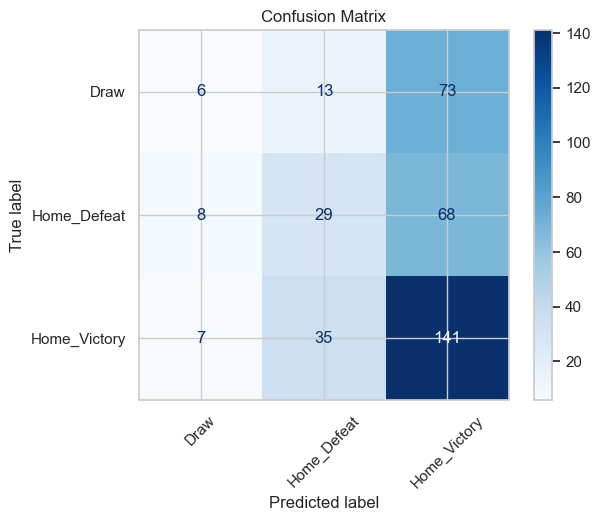

In [22]:
ConfusionMatrixDisplay.from_predictions(
    y_real_spanish,
    predictions_real_spanish,
    display_labels=['Draw', 'Home_Defeat', 'Home_Victory'],
    cmap='Blues',
    xticks_rotation=45
)
plt.title('Confusion Matrix')
plt.show()

# Lasse ma noch stehen

In [23]:
real_brier_scores2 = create_brier_scores(X_test = X_real, y_test = y_real, model = best_models['GradientBoostingClassifier'], dataset = real_bundesliga_dataset)
                    
real_brier_scores_week2 = real_brier_scores2.groupby('match_week').agg(brier_score=('brier_score', 'mean'))

print(f'Brier Score: {real_brier_scores2["brier_score"].mean()}')

Brier Score: 0.13576046286253296


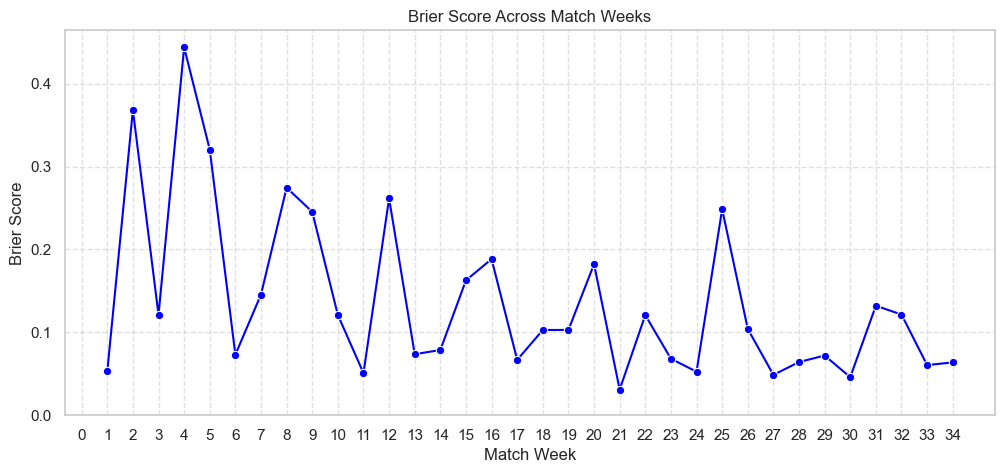

In [24]:
# Create the plot
plt.figure(figsize=(12, 5))
sns.lineplot(data=real_brier_scores_week, x='match_week', y='brier_score', marker='o', color='blue')

# Customize the plot
plt.xlabel('Match Week')
plt.ylabel('Brier Score')
plt.title('Brier Score Across Match Weeks')
plt.ylim(0, None)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(range(35))  # range(35) generates numbers 0 through 34


# Show the plot
plt.show()

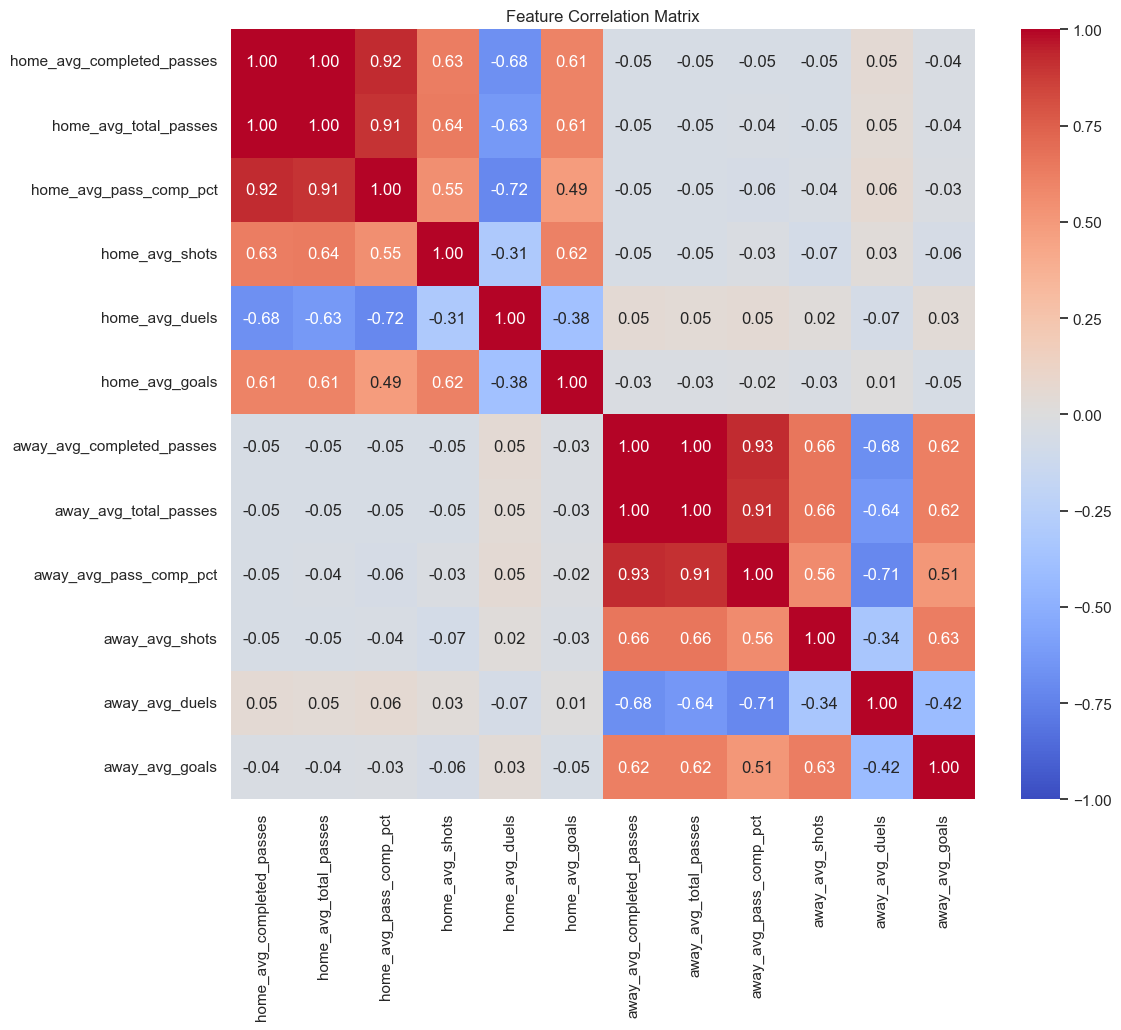

In [25]:
# Calculate correlation matrix (numerical features only)
corr_matrix = X_train.select_dtypes(include=['number']).corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm',
            center=0,
            vmin=-1, 
            vmax=1)
plt.title("Feature Correlation Matrix")
plt.show()

# Gathering some infomation about Teams

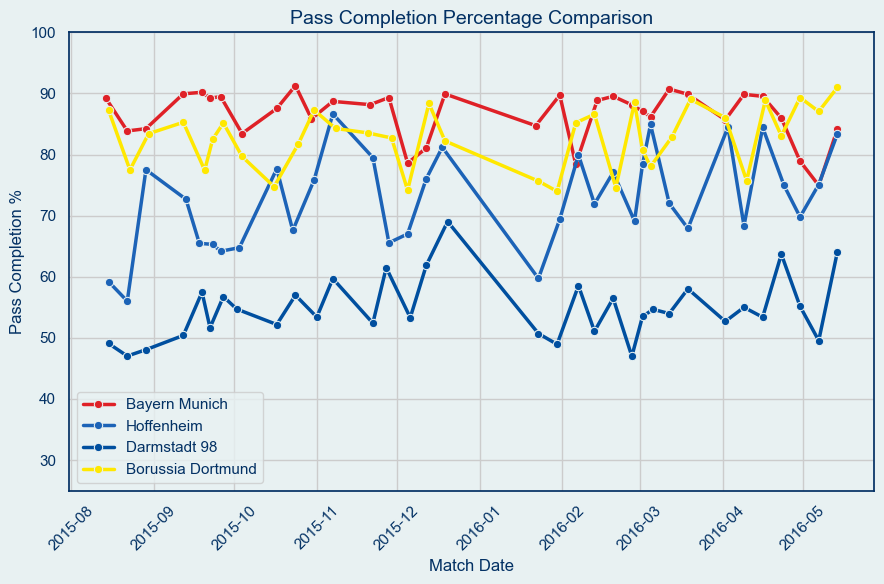

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define custom colors for each team
custom_colors = {
    'Bayern Munich': '#df2127',
    'Borussia Dortmund': '#ffe800',
    'Darmstadt 98': '#004F9F',
    'Hoffenheim': '#1c63b7',
    # Add more if needed
}

# Customize style options
background_color = '#e8f1f2'
legend_background_color = '#e8f1f2'
text_color = '#033164'
spine_color = '#033064'

# Filter data
pass_completion_rates = team_stats[['team', 'match_date', 'pass_completion_percentage']]
teams_to_plot = ['Bayern Munich', 'Borussia Dortmund', 'Darmstadt 98', 'Hoffenheim']
multi_team_data = pass_completion_rates[pass_completion_rates['team'].isin(teams_to_plot)]

# Create plot
plt.figure(figsize=(9, 6))
ax = sns.lineplot(data=multi_team_data,
                  x='match_date',
                  y='pass_completion_percentage',
                  hue='team',
                  palette=custom_colors,
                  marker='o',
                  markeredgecolor=background_color,  # Match marker edge color to background
                  linewidth=2.5)

# Customize colors
ax.set_facecolor(background_color)  # Plot background
plt.gcf().patch.set_facecolor(background_color)  # Figure background


# Customize text
ax.set_title('Pass Completion Percentage Comparison', fontsize=14, color=text_color)
ax.set_xlabel('Match Date', fontsize=12, color=text_color)
ax.set_ylabel('Pass Completion %', fontsize=12, color=text_color)
ax.tick_params(colors=text_color)
ax.xaxis.label.set_color(text_color)
ax.yaxis.label.set_color(text_color)

# Customize legend
legend = ax.legend()
legend.get_frame().set_facecolor(legend_background_color)
plt.setp(legend.get_texts(), color=text_color)
plt.setp(legend.get_title(), color=text_color)
for spine in ax.spines.values():
    spine.set_color(spine_color)
# Final plot adjustments
plt.xticks(rotation=45)
plt.ylim(25, 100)
plt.tight_layout()
plt.savefig('./Poster_stuff/Pass_completion.svg')
plt.show()
